# Step45, 계층을 모아두는 계층 

Layer 클래스에는 매개변수를 관리하는구조가 녹아있어서 매개변수를 직접 다루지 않아도 되어 편리  
그런데 Layer 인스턴스 자체도 관리가 필요.  
예 : 10층 신경망을 구현하려면 10개이 Layer 인스턴스를 관리해야함

Layer 클래스를 확장해본다.

## 45.1 Layer 클래스 확장 

Layer 클래스가 '다른 Layer'도 담을 수 있게 확장 

Layer 안에 다른 Layer가 들어가는 구조  
목표 : 바깥 Layer에서 그 안에 존재하는 모든 매개변수를 꺼낼 수 있도록 하는 것

In [1]:
# layers.py
class Layer:
    def __init__(self):
        self._params = set()
    
    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)):   # 1. Layer도 추가 
            self._params.add(name)
        super().__setattr__(name, value)
    
    def params(self):
        for name in self._params:
            obj = self.__dict__[name]

            if isinstance(obj, Layer):  # 2. Layer에서 매개변수 꺼내기 
                yield from obj.params()
            else:
                yield obj 


1. 인스턴스 변수를 설정할때, Layer 인스턴스 이름도 \_params에 추가  
Parameter 인스턴스와 Layer 인스턴스의 이름이 _params에 추가 

2, 매개변수를 꺼내는 처리  
params 메서드는 _params에서 name을 꺼내  
그 name에 해당하는 객체를 obj로 꺼냄  
obj가 Layer 인스턴스이면 obj.params() 호출  
이런식으로 Layer 속 Layer에서도 매개변수를 재귀적으로 꺼낼수 있다.

**CATION_** yield를 사용한 함수를 generator라고 한다.  
generator를 사용하여 또 다른 generator를 만들고자 할때는 yield from을 사용한다.

In [2]:
import dezero.layers as L 
import dezero.functions as F 
from dezero import Layer 

model = Layer()             # 인스턴스를 생성
model.l1 = L.Linear(5)      # model의 인스턴스 변수로 Linear 인스턴스를 추가 
model.l2 = L.Linear(3)      

# 추론을 수행하는 함수 
def predict(model, x):
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y 

# 모든 매개변수에 접근 
for p in model.params():    # model.params()로 model 내에 존재하는 모든 매개변수에 접근할수 있다.
    print(p)

# 모든 매개변수의 기울기를 재설정 
model.cleargrads()

variable([0. 0. 0. 0. 0.])
variable(None)
variable([0. 0. 0.])
variable(None)


한편 Layer 클래스를 더 편리하게 사용하는 방법  
Layer 클래스를 상속하여 모델 전체를 하나의 '클래스'로 정의하는 방법

In [3]:
from dezero.layers import Layer

# TwoLayerNet이라는 클래스 하나에 신경망에 필요한 모든 코드를 집약
class TwoLayerNet(Layer):                       # Layer를 상속
    def __init__(self, hiddne_size, out_size):  # 필요한 Layer들을 생성하여 
        super().__init__()
        self.l1 = L.Linear(hiddne_size)         # self.l1 = ... 형태로 설정
        self.l2 = L.Linear(out_size)

    def forward(self, x):                       # 추론을 수행하는 코드
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

여기서 선보인 '객체지향식 모델 정의 방법'(모델을 클래스 단위로 정의)은 체이너가 최초로 제안  
이 후 파이토치와 텐서플로등 많은 다른 프레임워크에서 보편적으로 사용하는 방식이되었다.

## 45.2 Model 클래스

모델 : 복잡한 패턴이나 규칙이 숨어 있는 현상을 수식을 사용하여 단순하게 표현한 것  
신경망도 수식으로 표현할 수 있는 함수이며, 그것을 가리켜 '모델'이라고 한다.

이번절에서는 모델을 표현하기 위한 Model 클래스를 새로 만든다.  
Model 클래스는 Layer클래스의 기능을 이어받으며 **시각화 메서드**가 하나 추가된다.

In [4]:
# models.py
from dezero import Layer
from dezero import utils 

class Model(Layer):
    def plot(self, *inputs, to_file='model.png'):
        y = self.forward(*inputs)
        return utils.plot_dot_graph(y, verbose=True, to_file=to_file)

이와 같이 Model은 Layer를 상속한다.  
따라서 Model 클래스를 앞에서 본 Layer 클래스처럼 활용할 수 있다.  
class TwoLayerNet(Model):

plot은 인수 *inputs로 전달받은 데이터를 forward 메서드로 계산한다음  
생성된 계산 그래프를 이미지 파일로 보낸다.

utils.plot_dot_graph 함수의 인수에 대해 verbose=True로 설정하면 ndarray 인스턴스의 형상과 타입도 계산 그래프에 표시해준다.

마지막으로 Model 클래스를 쉽게 임포트할 수 있도록 dezero/\__init\__.py에 다음 줄을 추가한다.

~~~python
from dezero.models import Model
~~~

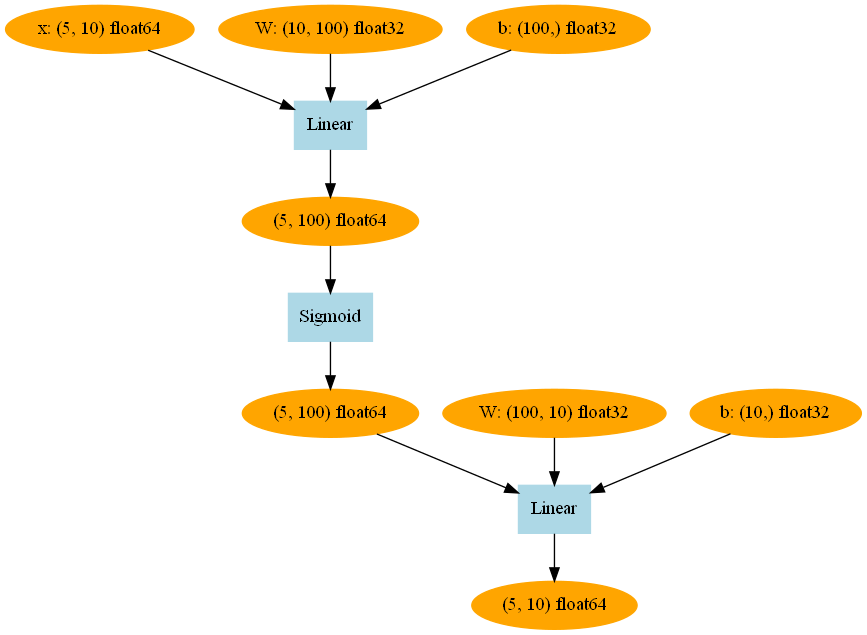

In [5]:
import numpy as np 
from dezero import Variable, Model 
import dezero.layers as L 
import dezero.functions as F 

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y 

x = Variable(np.random.randn(5,10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

## 45.3 Model을 사용한 문제 해결 

sin 함수로 생성한 데이터셋 회귀 문제를 Model 클래스를 이용하여 다시 풀어본다.

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126008)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.1231190572064935)
variable(0.0788816650635515)
variable(0.07655073683421633)
variable(0.07637803086238226)
variable(0.07618764131185571)


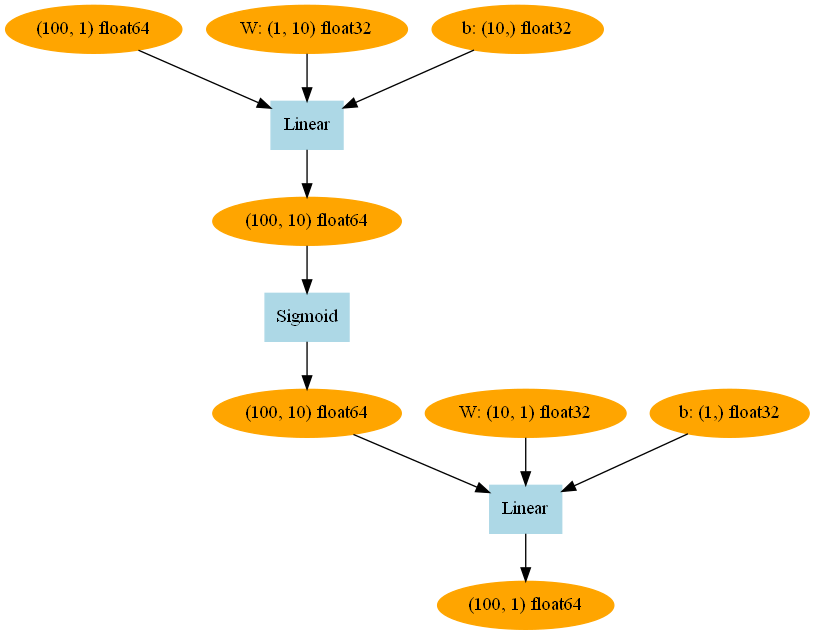

In [6]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero import Model
import dezero.layers as L
import dezero.functions as F
import matplotlib.pyplot as plt

# 데이터셋 생성 
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 * np.pi * x) + np.random.rand(100,1)

# 하이퍼파라미터 설정 
lr = 0.2 
max_iter = 10000
hidden_size = 10

# 모델 정의
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y 
    
model = TwoLayerNet(hidden_size, 1)

# 학습시작 
for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    for p in model.params():
        p.data -= lr * p.grad.data 
    
    if i % 1000 == 0:
        print(loss)

model.plot(x)

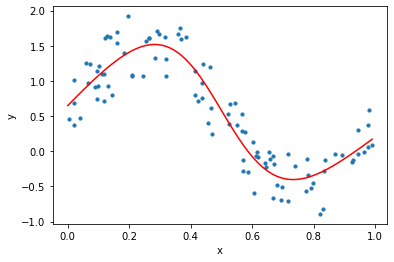

In [7]:
# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')

t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = model(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

## 45.4 MLP 클래스 

MLP : Multi-Layer Perceptron, 다층 퍼셉트론

앞으로를 위해 더 범용적인 완전연결계층 신경망을 구현해본다.

In [8]:
import numpy as np 
from dezero import Variable, Model 
import dezero.functions as F 
import dezero.layers as L 

class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):
        super().__init__()
        self.activation = activation
        self.layers = []

        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer)
            self.layers.append(layer)

    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)

초기화에서는 인수로 fc_output_sizes와 activation을 받는다.  
여기서 fc는 full connect  
fc_output_sizes는 신경망을 구성하는 완전연결계층들의 출력 크기를 튜플 또는 리스트로 지정  

예 : (10,1)을 건내면 2개의 Linear 계층을 만들고, 첫번째 계층의 출력 크기는 10, 두 번째 계층의 출력 크기는 1로 구성 

다음과 같이 'N층'을 쉽게 구현할 수 있다.

In [9]:
model = MLP((10,1)) # 2층 
model = MLP((10,20,30,40,1))    # 5층

위 MLP 클래스는 계속 사용할것이므로 dezero/models.py에 추가